In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# !pip install keras --upgrade

In [3]:
print(tf.__version__)

2.8.0


In [4]:
data = pd.read_csv(r'./Data/AAPL.csv')

In [5]:
data.head()

,trade_date,open,high,low,close,volume,dividend,split
0,1980-12-12,0.128348,0.128906,0.128348,0.128348,469033600,0,1
1,1980-12-15,0.122210,0.122210,0.121652,0.121652,175884800,0,1
2,1980-12-16,0.113281,0.113281,0.112723,0.112723,105728000,0,1
3,1980-12-17,0.115513,0.116071,0.115513,0.115513,86441600,0,1
4,1980-12-18,0.118862,0.119420,0.118862,0.118862,73449600,0,1


In [6]:
data['ret'] = data['close'].pct_change()*np.sqrt(252)
data['vol'] = data['ret'].rolling(100).std()

Text(0.5, 1.0, 'Volatility - AAPL')

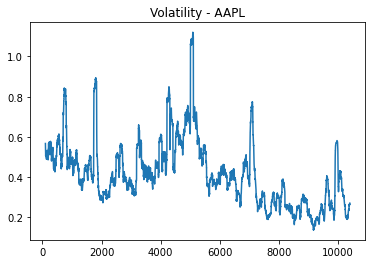

In [7]:
data['vol'].plot()
plt.title('Volatility - AAPL')

In [8]:
vol = data['vol'].dropna().values
time_valid = data['vol'].dropna().index

In [9]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """
  
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset

In [10]:
def plot_series(x, y, format="-", start=0, end=None, 
                title=None, xlabel=None, ylabel=None, legend=None ):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    
    # Check if there are more than two series to plot
    if type(y) is tuple:

      # Loop over the y elements
      for y_curr in y:

        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
      plt.legend(legend)

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

In [11]:
# Define the split time
split_time = 7000

# Get the train set 
time_train = time_valid[:split_time]
x_train = vol[:split_time]

# Get the validation set
time_valid = time_valid[split_time:]
x_valid = vol[split_time:]

In [12]:
print(len(time_train))
print(len(time_valid))

7000
3296


In [13]:
# Parameters
window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

# Generate the dataset windows
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the ver

In [14]:
# Build the Model
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                      strides=1,
                      activation="relu",
                      padding='causal',
                      input_shape=[window_size, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

 # Print the model summary 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 30, 64)            256       
                                                                 
 lstm (LSTM)                 (None, 30, 64)            33024     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 30)                1950      
                                                                 
 dense_1 (Dense)             (None, 10)                310       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
 lambda (Lambda)             (None, 1)                 0

In [15]:
# Get initial weights
init_weights = model.get_weights()

In [16]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
218/218 [==============================] - 8s 9ms/step - loss: 6.6615 - lr: 1.0000e-08
Epoch 2/100
218/218 [==============================] - 2s 8ms/step - loss: 1.8310 - lr: 1.1220e-08
Epoch 3/100
218/218 [==============================] - 2s 8ms/step - loss: 1.0779 - lr: 1.2589e-08
Epoch 4/100
218/218 [==============================] - 2s 8ms/step - loss: 0.7638

Epoch 74/100
218/218 [==============================] - 2s 9ms/step - loss: 3.2509 - lr: 4.4668e-05
Epoch 75/100
218/218 [==============================] - 2s 8ms/step - loss: 3.7082 - lr: 5.0119e-05
Epoch 76/100
218/218 [==============================] - 2s 8ms/step - loss: 4.2204 - lr: 5.6234e-05
Epoch 77/100
218/218 [==============================] - 2s 8ms/step - loss: 4.7996 - lr: 6.3096e-05
Epoch 78/100
218/218 [==============================] - 2s 8ms/step - loss: 5.4410 - lr: 7.0795e-05
Epoch 79/100
218/218 [==============================] - 2s 8ms/step - loss: 6.1689 - lr: 7.9433e-05
Epoch 80/100
218/218 [==============================] - 2s 8ms/step - loss: 6.9808 - lr: 8.9125e-05
Epoch 81/100
218/218 [==============================] - 2s 8ms/step - loss: 7.8977 - lr: 1.0000e-04
Epoch 82/100
218/218 [==============================] - 2s 8ms/step - loss: 8.9229 - lr: 1.1220e-04
Epoch 83/100
218/218 [==============================] - 2s 8ms/step - loss: 10.0730 - lr: 1.2589e-04

(1e-08, 0.001, 0.0, 100.0)

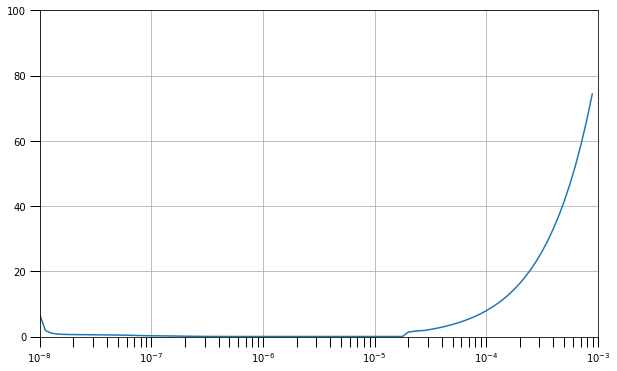

In [17]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 100])

In [18]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Reset the weights
model.set_weights(init_weights)

In [19]:
# Set the learning rate
learning_rate = 5e-6

# Set the optimizer 
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [20]:
# Train the model
history = model.fit(train_set,epochs=100)

Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
218/218 [==============================] - 6s 9ms/step - loss: 0.4909 - mae: 0.7893
Epoch 2/100
218/218 [==============================] - 2s 9ms/step - loss: 0.0442 - mae: 0.2292
Epoch 3/100
218/218 [==============================] - 2s 9ms/step - loss: 0.0208 - mae: 0.1540
Epoch 4/100
218/218 [==============================] - 2s 8ms/step - loss: 0.0046 - mae: 0

218/218 [==============================] - 2s 8ms/step - loss: 7.1607e-04 - mae: 0.0244
Epoch 75/100
218/218 [==============================] - 2s 8ms/step - loss: 6.2098e-04 - mae: 0.0213
Epoch 76/100
218/218 [==============================] - 2s 8ms/step - loss: 6.0286e-04 - mae: 0.0213
Epoch 77/100
218/218 [==============================] - 2s 8ms/step - loss: 6.0991e-04 - mae: 0.0217
Epoch 78/100
218/218 [==============================] - 2s 8ms/step - loss: 6.1533e-04 - mae: 0.0219
Epoch 79/100
218/218 [==============================] - 2s 8ms/step - loss: 6.2776e-04 - mae: 0.0227
Epoch 80/100
218/218 [==============================] - 2s 8ms/step - loss: 5.7148e-04 - mae: 0.0208
Epoch 81/100
218/218 [==============================] - 2s 8ms/step - loss: 6.1008e-04 - mae: 0.0221
Epoch 82/100
218/218 [==============================] - 2s 8ms/step - loss: 5.6851e-04 - mae: 0.0206
Epoch 83/100
218/218 [==============================] - 2s 8ms/step - loss: 5.6946e-04 - mae: 0.0208
Epo

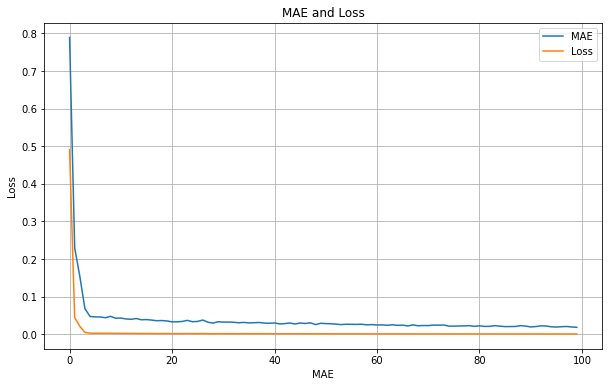

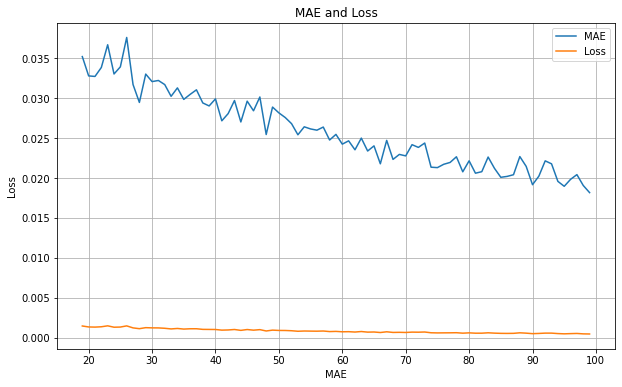

In [21]:
# Get mae and loss from history log
mae=history.history['mae']
loss=history.history['loss']

# Get number of epochs
epochs=range(len(loss)) 

# Plot mae and loss
plot_series(
    x=epochs, 
    y=(mae, loss), 
    title='MAE and Loss', 
    xlabel='MAE',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )

# Only plot the last 80% of the epochs
zoom_split = int(epochs[-1] * 0.2)
epochs_zoom = epochs[zoom_split:]
mae_zoom = mae[zoom_split:]
loss_zoom = loss[zoom_split:]

# Plot zoomed mae and loss
plot_series(
    x=epochs_zoom, 
    y=(mae_zoom, loss_zoom), 
    title='MAE and Loss', 
    xlabel='MAE',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )

In [22]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    # Get predictions on the entire dataset
    forecast = model.predict(dataset)
    
    return forecast

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set

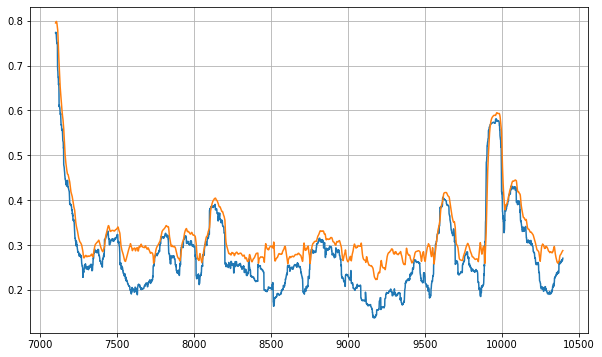

In [23]:
# Reduce the original series
forecast_series = vol[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

Faster

In [24]:
# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-7, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
history = model.fit(train_set,epochs=10)

Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
218/218 [==============================] - 5s 8ms/step - loss: 4.1390e-04 - mae: 0.0156
Epoch 2/10
218/218 [==============================] - 2s 8ms/step - loss: 4.0806e-04 - mae: 0.0154
Epoch 3/10
218/218 [==============================] - 2s 8ms/step - loss: 4.0747e-04 - mae: 0.0154
Epoch 4/10
218/218 [==============================] - 2s 8ms/step - loss: 4.0800e

In [25]:
def decayed_learning_rate(step):
  return initial_learning_rate * decay_rate ^ (step / decay_steps)

In [26]:
# Set the initial learning rate
initial_learning_rate=1e-7

# Define the scheduler
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=400,
    decay_rate=0.96,
    staircase=True)

# Set the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
history = model.fit(train_set,epochs=40)

Epoch 1/40
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
218/218 [==============================] - 6s 9ms/step - loss: 4.0704e-04 - mae: 0.0154
Epoch 2/40
218/218 [==============================] - 2s 9ms/step - loss: 4.0820e-04 - mae: 0.0153
Epoch 3/40
218/218 [==============================] - 2s 9ms/step - loss: 4.0785e-04 - mae: 0.0153
Epoch 4/40
218/218 [==============================] - 2s 9ms/step - loss: 4.0716e

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set

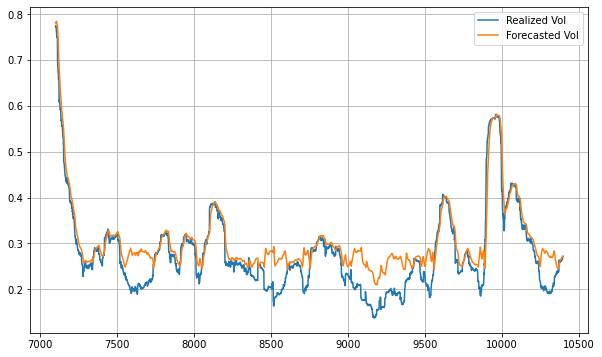

In [27]:
# Reduce the original series
forecast_series = vol[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results),legend=['Realized Vol','Forecasted Vol'])

In [28]:
# Compute the MAE
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

0.03197542